<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_3_%D0%9E_%D0%B2%D0%BA%D1%83%D1%81%D0%BD%D0%BE%D0%B9_%D0%B8_%D0%B7%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D0%B8%D1%89%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Проект 3. О вкусной и здоровой пище

In [ ]:
import pandas as pd
 
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)
  
# rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews', 'url_TA', 'id_TA']
rest.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


#Ответы на вопросы заданий

In [105]:
import pandas as pd
import numpy as np

RANDOM_SEED = 36

# rest.loc[0:100, 'reviews'].to_list()
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)

rest.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)
rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews']

# 2.1 Задание 1
# Какие столбцы НЕ содержат пропущенных (None) значений?
# rest.info()
 
print('\nЕсть пропуски в столбцах:\n',
*list(rest.loc[:, rest.apply(pd.isna).any(axis=0)].columns))
 
print('\nНет пропусков в столбцах:\n',
*list(rest.loc[:, ~rest.apply(pd.isna).any(axis=0)].columns), '\n')
 
# 2.2 Задание 2
#rest.loc[0, :].apply(type) != str
 
# 2.3 Задание 3
#Приведение 'кухни' к списку
#rest.loc[0, 'Cuisine Style'].split(', ')
#[s.replace('[', '').replace(']', '').replace("'", "") for s in rest.loc[0, 'Cuisine Style'].s изplit(', ')]

# 4.1 Вопросы о ценах
rest.loc[:, 'price_range'].dropna().unique()
rest.loc[rest.loc[:, 'price_range'] == '$$ - $$$', 'price_range'].count()

# 4.2 Вопрос о городах
len(rest.loc[:, 'city'].unique())

# 4.3 Вопросы о кухнях
rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].fillna(value='[]').apply(
    lambda cuisine_list_for_id: \
    [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]
)

cuisine_list = []
for cuisine in rest.loc[:, 'cuisine']:
    cuisine_list += cuisine
cuisines_total = len(set(cuisine_list).difference(set([''])))
# cuisines_total = len(set(cuisine_list)) - 1

from collections import Counter
Counter(cuisine_list).most_common(1)[0][0]

round(
    rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1).mean(),
    1
)

# 4.4 Вопросы об отзывах
import re
from datetime import datetime as dat

def rev_dates(s):
    date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
    str_date_ls = date_regex.findall(s)
    if str_date_ls != []:
        # str_date_ls = date_regex.findall(s)
        enum = list(enumerate(str_date_ls))
        f = ['%m/%d/%Y' if int(e[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y' for e in enum]
        return [dat.strptime(e[1], f[e[0]]) for e in enum] #dat.strptime(str_date_ls[0], f[0])
    else:
        return [dat(1970, 1, 1, 0, 0)] #strftime('%m/%d/%Y', '01/01/1970')

# когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
most_recent_rev_date =\
rest.loc[:, 'reviews'].apply(lambda s: rev_dates(s)[0]).max()
dat.strftime(most_recent_rev_date, '%Y-%m-%d') #->2018-02-26

# Какое максимальное количество дней отделяет даты публикации отзывов,
# размещённых на сайте ресторана? Введите количество дней в виде целого числа.
def last_rev_date_delta(dates):
    if len(dates) >= 3:
        return abs(dates[2] - dates[1]).days
    else:
        return abs(dates[0] - dates[-1]).days

# добавляем в данные столбец с кол-вом дней между двумя последними отзывами
rest.loc[:, 'delta'] =\
rest.loc[:, 'reviews'].apply(lambda s: last_rev_date_delta(rev_dates(s))) #.sort_values(ascending=False)
# rest['delta'].dt.days.astype(int).hist(log=True, bins=50);

#считаем кол-во кухонь в меню ресторана, добавляем соотв. столбец
rest.loc[:, 'n_of_cuisines'] = rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1)
# rest.loc[:, 'n_of_cuisines'].hist(log=True, bins=50);

# добавляем столбец с населением города, в кот. находится ресторан
# rest.loc[:, 'city'].unique()
population = {'Paris': 2176, 'Stockholm': 1656, 'London': 10840, 'Berlin': 3664,
       'Munich': 1553, 'Oporto': 232, 'Milan': 3144, 'Bratislava': 433,
       'Vienna': 1911, 'Rome': 2860, 'Barcelona': 1620, 'Madrid': 3223,
       'Dublin': 555, 'Brussels': 1209, 'Zurich': 415, 'Warsaw': 1794,
       'Budapest': 1752, 'Copenhagen': 799, 'Amsterdam': 873, 'Lyon': 516,
       'Hamburg': 1899, 'Lisbon': 507, 'Prague': 1324, 'Oslo': 697, 
       'Helsinki': 658, 'Edinburgh': 488, 'Geneva': 202, 'Ljubljana': 296,
       'Athens': 664, 'Luxembourg': 125, 'Krakow': 781}
rest.loc[:, 'population'] = rest.loc[:, 'city'].apply(lambda city: population[city])

# добавляем столбец с подушевым ВВП по ППС города, в кот. нах. ресторан
is_capital = {'Paris': 1, 'Stockholm': 1, 'London': 1, 'Berlin': 1,
       'Munich': 0, 'Oporto': 0, 'Milan': 0, 'Bratislava': 1,
       'Vienna': 1, 'Rome': 1, 'Barcelona': 0, 'Madrid': 1,
       'Dublin': 1, 'Brussels': 1, 'Zurich': 0, 'Warsaw': 1,
       'Budapest': 1, 'Copenhagen': 1, 'Amsterdam': 1, 'Lyon': 0,
       'Hamburg': 0, 'Lisbon': 1, 'Prague': 1, 'Oslo': 1, 
       'Helsinki': 1, 'Edinburgh': 0, 'Geneva': 0, 'Ljubljana': 1,
       'Athens': 1, 'Luxembourg': 1, 'Krakow': 0}
rest.loc[:, 'is_capital'] = rest.loc[:, 'city'].apply(lambda city: is_capital[city])

# добавляем столбец с подушевым ВВП по ППС города, в кот. нах. ресторан
gdp_per_capita = {
    'Paris': 61883, 'Stockholm': 61754, 'London': 58827, 'Berlin': 37601,
    'Munich': 69844, 'Oporto': 24819, 'Milan': 51768, 'Bratislava': 67841,
    'Vienna': 46787, 'Rome': 41475, 'Barcelona': 45752, 'Madrid': 43074,
    'Dublin':30000, 'Brussels': 54634, 'Zurich': 64302, 'Warsaw': 49722,
    'Budapest': 37399, 'Copenhagen': 54197, 'Amsterdam': 60857, 'Lyon': 46913,
    'Hamburg': 52947, 'Lisbon': 34782, 'Prague': 48160, 'Oslo': 64673,
    'Helsinki': 49760, 'Edinburgh': 44059, 'Geneva': 62115, 'Ljubljana': 39763,
    'Athens': 32167, 'Luxembourg': 88312, 'Krakow': 29695
}
rest.loc[:, 'gdp'] = rest.loc[:, 'city'].apply(lambda city: gdp[city])


#количество предприятий общепита в стране нахождения ресторана
n_of_food_serv = {
    'Paris': 161466, 'Stockholm': 23208, 'London': 88841, 'Berlin': 136091,
    'Munich': 136091, 'Oporto': 31363, 'Milan': 155875, 'Bratislava': 10917,
    'Vienna': 27348, 'Rome': 155875, 'Barcelona': 72657, 'Madrid': 72657,
    'Dublin': 7993, 'Brussels': 30773, 'Zurich': 11961, 'Warsaw': 39291,
    'Budapest': 16850, 'Copenhagen': 8983, 'Amsterdam': 30502, 'Lyon': 161466,
    'Hamburg': 136091, 'Lisbon': 31363, 'Prague': 45623, 'Oslo': 6605,
    'Helsinki': 7769, 'Edinburgh': 88841, 'Geneva': 11961, 'Ljubljana': 4369,
    'Athens': 39978, 'Luxembourg': 1475, 'Krakow': 39291
}
rest.loc[:, 'n_of_food_serv'] = rest.loc[:, 'city'].\
    apply(lambda city: n_of_food_serv[city])

#количество ресторанов в городе согласно датасету на душу населения города
n_of_rest_per_capita =\
    rest.loc[:, 'city'].value_counts() / pd.Series(population)
rest.loc[:, 'n_of_rest_per_capita'] = rest.loc[:, 'city'].\
    apply(lambda city: n_of_rest_per_capita[city])

#получаем dummies из столбца cuisine и  прикрепляем его к осн. датафрейму 
# rest = pd.concat([
#          rest,
#          pd.get_dummies(rest.explode('cuisine'), columns=['cuisine'], prefix=None).
#          sum(level=0).iloc[:, -cuisines_total:-1]],
#          axis=1
# )

#квантизуем признак price_range
#price_ranges = rest.loc[:, 'price_range'].dropna().unique()

price_range_quantize = {
    '$': 1, '$$ - $$$': 2, '$$$$': 3
}
rest.loc[:, 'price_range']=\
rest.loc[:, 'price_range'].apply(lambda x: 0 if pd.isna(x) else price_range_quantize[x])
# display(rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'])

# Какие признаки возьмем в модель?
# ==================================
# ranking
# rev_number
# delta - кол-во дней между двумя последними отзывами +
# n_of_cuisines - кол-во кухонь, представленных в ресторане +
# population - население города, в котором расположен ресторан +
# gdp - подушевой ВВП по ППС города (USD)


Есть пропуски в столбцах:
 cuisine price_range rev_number

Нет пропусков в столбцах:
 id city ranking rating reviews 



In [74]:
# l = cuisine_list.sort()
cuisine_set = set(cuisine_list).difference(set(['']))
# (cuisine_set.intersection(set(rest.loc[10, 'cuisine'])))
rest.loc[:, 'cuisine'].apply(lambda cuisine: cuisine)

set()

#Заполнение пропусков

In [106]:
# before = rest.loc[rest.loc[:, 'price_range'] != 0 , 'price_range']
# pd.get_dummies(rest, columns=['Cuisine Style'])
# rest.loc[rest.loc[:, 'Cuisine Style'].apply(lambda r: pd.isna(r)), 'Cuisine Style']

#первый вариант заполнения пропусков в rev_number средним по всем ресторанам
mean_NoR = rest.loc[:, 'rev_number'].mean()
rest.loc[:, 'rev_number'] = \
rest.loc[:, 'rev_number'].apply(lambda r: r if not(pd.isna(r)) else mean_NoR)

#второй вариант заполнения пропусков в rev_number средним по городу
# mean_NoR_by_city = dict([
#       (city, rest.loc[rest.loc[:, 'city'] == city, 'rev_number'].mean())\
#       for city in rest.loc[:, 'city'].unique()
# ])

rest.loc[:, 'rev_number'].\
    fillna(rest.loc[:, 'city'].\
           apply(lambda c: mean_NoR_by_city[c]), inplace=True)

#заполняем пропуски в price_range - под вопросом

from random import randint

def fill_price(city, city_pr_distr): # distr -> distr[city][distr[city].index != 0]
    borders = [city_pr_distr[0:i+1].sum() for i in range(len(city_pr_distr))]
    
    pick_rand = randint(0, borders[-1])
    for border in enumerate(borders):
        if pick_rand < border[1]:
            return city_pr_distr.index[border[0]]

distr = rest.groupby('city')['price_range'].value_counts()

## rest.query('price_range == 0')['price_range'] = \
## rest.query('price_range == 0')['city'].apply(
##     lambda city: fill_price(city, distr[city][distr[city].index != 0])
##)

rest.loc[rest.loc[:, 'price_range'] == 0, 'price_range'] = \
rest.loc[rest.loc[:, 'price_range'] == 0, 'city'].apply(
    lambda city: fill_price(city, distr[city][distr[city].index != 0])
)
# rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'] = 0

rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'] = \
rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'city'].apply(
    lambda city: fill_price(city, distr[city][distr[city].index != 0])
)

#заполняем пропуски в price_range

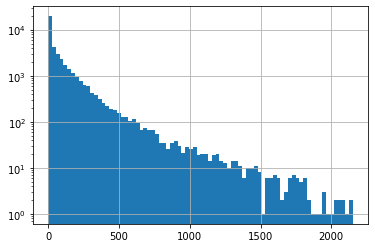

In [39]:
# rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'] = 0
mask = rest.loc[:, 'price_range'].apply(pd.isna)

# rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'] = 0
df = rest.loc[mask, :]
df.index #.groupby('city')['price_range'].value_counts()

# rest.loc[rest.loc[:, 'delta'] > -1, 'delta'] = 0
(rest.loc[:, 'delta']).hist(bins=80, log=True);



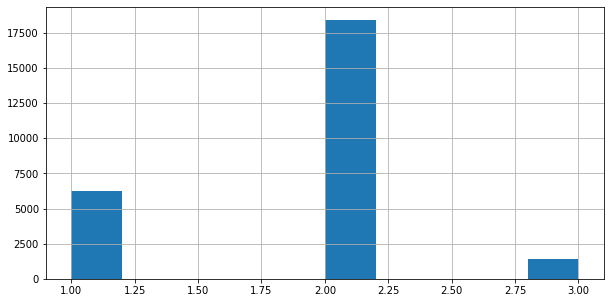

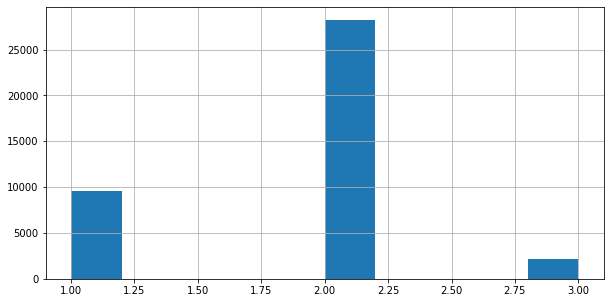

In [ ]:
from random import randint
import matplotlib.pyplot as plt
# 
before.hist();

# se[city][se[city].index != 0].plot(kind='barh');
plt.show()

rest.loc[rest.loc[:, 'price_range'] != 0, 'price_range'].hist();
# test = pd.Series([fill_price(city, se[city][se[city].index != 0]) for q in range(1146)])
# test.value_counts().plot(kind='barh');
# test.value_counts()


#Полиномиальные черты

In [75]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(
    rest.loc[:, ['n_of_cuisines', 'population', 'rev_number', 'ranking']]
)
# pd.DataFrame(poly_features).iloc[:, 1:9]
rest = pd.concat([
         rest,
         pd.DataFrame(poly_features) #.iloc[:, 1:9]
         ],
         axis=1
)
rest
# rest.loc[:, 'city'].unique()
# pd.get_dummies(rest.explode('cuisine'), columns=['cuisine'], prefix='').\
#          sum(level=0).iloc[:, -125:-1]
# rest.explode('cuisine')

ValueError: ignored

#Черновик 1

In [ ]:
# import re
# from datetime import datetime as dat

# date_regex.findall(s)[0][0:2] <\
# date_regex.findall(s)[0][3:5] #->11 #->18

st = "[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]"
# rev_date(s)
# date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
# str_date_ls = date_regex.findall(st)

# r

# rev_dates(st)
# str_date_ls, f, enum

# se = rest.loc[:, 'reviews'].apply(lambda s: len(rev_dates(s)))
# rest[se==1]['reviews']
# rest.loc[[9254, 23348], 'reviews'].to_list()
# rest.loc[rest.loc[:, 'reviews'].apply(lambda s: ("'], ['" in s) or (s == "[[], []]")), 'reviews'].index.to_list()
# se = rest.loc[:, 'reviews'].apply(lambda s: s.count('['))
# rest[se!=3]['reviews'].to_list()

se = rest.loc[:, 'reviews'].apply(lambda s: len(rev_dates(s)))
rest[se==1]['reviews']
rest.loc[[9254, 23348], 'reviews'].to_list()
rest.loc[rest.loc[:, 'reviews'].apply(lambda s: ("'], ['" in s) or (s == "[[], []]")), 'reviews'].index.to_list()
se = rest.loc[:, 'reviews'].apply(lambda s: s.count('['))
rest[se!=3]['reviews'].to_list()

["[['Good food, attentive staff', 'Sternstraße 125, Schanzenviertel, [59], ju...'], ['05/10/2015', '07/05/2014']]",
 "[['Nice lunch for a hungry group[ of travelle...', 'Tasty salad and sandwich'], ['10/24/2017', '01/12/2017']]",
 "[['Veramente Italiano [Really Italian]', 'Lunch on a Sunday'], ['12/11/2017', '11/19/2017']]"]

In [ ]:
#Предобработка
# rest.loc[0, :].apply(type)
# rest.dropna(axis=0, inplace=True)

rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].apply(
    lambda cuisine_list_for_id: \
        [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]\
            if not(pd.isna(cuisine_list_for_id)) else []
)

            # rest.loc[0, 'Cuisine Style'][0]
            # rest.get_dummies()
# rest

ValueError: ignored

In [ ]:
# rest.loc[:, 'n_of_cuisines']



#Данные в модель

,ranking,price_range,rev_number,delta,n_of_cuisines,is_capital,gdp,n_of_food_serv,n_of_rest_per_capita
0,5570.0,2.0,194.0,41,3,1,61883,161466,2.250460
1,1537.0,2.0,10.0,382,1,1,61754,23208,0.495169
2,353.0,3.0,688.0,2,7,1,58827,88841,0.531089
3,3458.0,2.0,3.0,0,1,1,37601,136091,0.588155
4,621.0,2.0,84.0,272,3,0,69844,136091,0.575016
...,...,...,...,...,...,...,...,...,...
39995,500.0,2.0,79.0,34,4,0,51768,155875,0.678435
39996,6341.0,2.0,542.0,9,5,1,61883,161466,2.250460
39997,1652.0,2.0,4.0,3127,2,1,61754,23208,0.495169
39998,641.0,2.0,70.0,23,5,1,49722,39291,0.405240


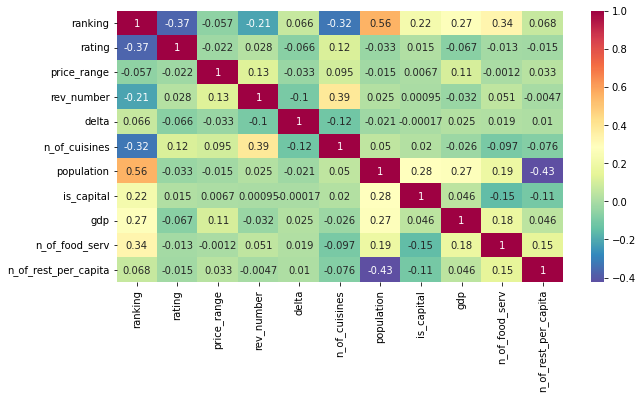

In [107]:
import seaborn as sns
# rest_m = rest.loc[:, ['ranking', 'rev_number', 'n_of_cuisines', 'delta', 'population']]
rest_m = rest.drop(['id', 'city', 'cuisine', 'rating',  'reviews', 'population'],
                   axis=1)
sns.heatmap(rest.corr(), annot = True, cmap = 'Spectral_r');
rest_m

# Создаём, обучаем и тестируем модель

1 run MAE: 0.1825625
2 run MAE: 0.1838125
3 run MAE: 0.184
4 run MAE: 0.1818125
5 run MAE: 0.1823125

5 runs mean MAE: 0.1829


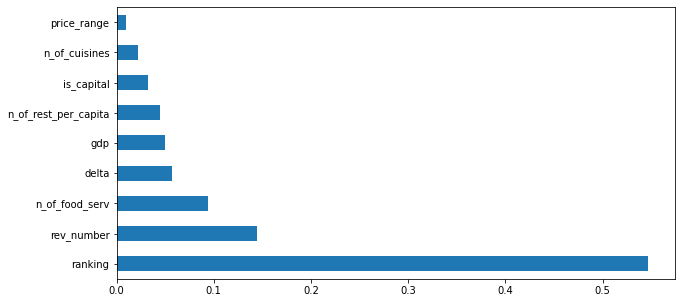

In [108]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = rest.drop(['Restaurant_id', 'Rating'], axis = 1)  
X = rest_m
y = rest.loc[:, 'rating']
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
# Импортируем необходимые библиотеки:  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

n = 5
mae = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
     
    # Создаём модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=1, random_state=RANDOM_SEED)  
      
    # Обучаем модель на тестовом наборе данных  
    regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
    y_pred = regr.predict(X_test)

    y_pred = (y_pred*2).round()/2
 
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
    mae += [metrics.mean_absolute_error(y_test, y_pred)]
    print(f'{i+1} run MAE: {mae[i]}')
print(f'\n{n} runs mean MAE: {sum(mae)/len(mae)}')

plt.rcParams['figure.figsize'] = (10, 5)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh');

# 5 runs mean MAE: 0.1856125 - без price_range
# 5 runs mean MAE: 0.18478749999999997 - price_range заполнен с сохранением внутригородского распределения
# 5 runs mean MAE: 0.1867
# 5 runs mean MAE: 0.1820875 - price_range заполнен нулями
# 5 runs mean MAE: 0.1843375 - price_range заполнен нулями, добавлен n_of_rest
# 5 runs mean MAE: 0.1832625 - price_range заполнен нулями,
#                              добавлен n_of_rest_per_capita вместо n_of_rest и population
# 5 runs mean MAE: 0.1825875 - price_range заполнен нулями,
#                              добавлен n_of_rest_per_capita вместо n_of_rest и population,
#                              добавлены dummies-переменные из cuisines
# runs mean MAE: 0.1829